In [1]:
# Module import

from __future__ import print_function

from IPython.display import Image
import sys
import pandas as pd

# To use interact -- IPython widget
#
#from ipywidgets import interact, interactive, fixed, interact_manual
#import ipywidgets as widgets


# append to path the folder that contains the analytic scanner
sys.path.append('../GaiaLab/scan/analytic_scanner')
# local imports
#from gaia_analytic_toymodel import *

from scipy import interpolate
import timeit

import frame_transformations as ft
from scanner import Scanner
from satellite import Satellite
from source import Source

import constants as const

from quaternion import Quaternion
from agis import Agis
from agis import Calc_source
from agis_functions import *

from analytic_plots import *

import astropy.units as u
import time
from scipy import sparse as sps
from astropy.coordinates import SkyCoord
import healpy as hp

# Ipython magics
%load_ext autoreload
%autoreload 2
%matplotlib notebook 
# %matplotlib widget
# %matplotlib ipympl
%reload_ext autoreload


# For scaling: 


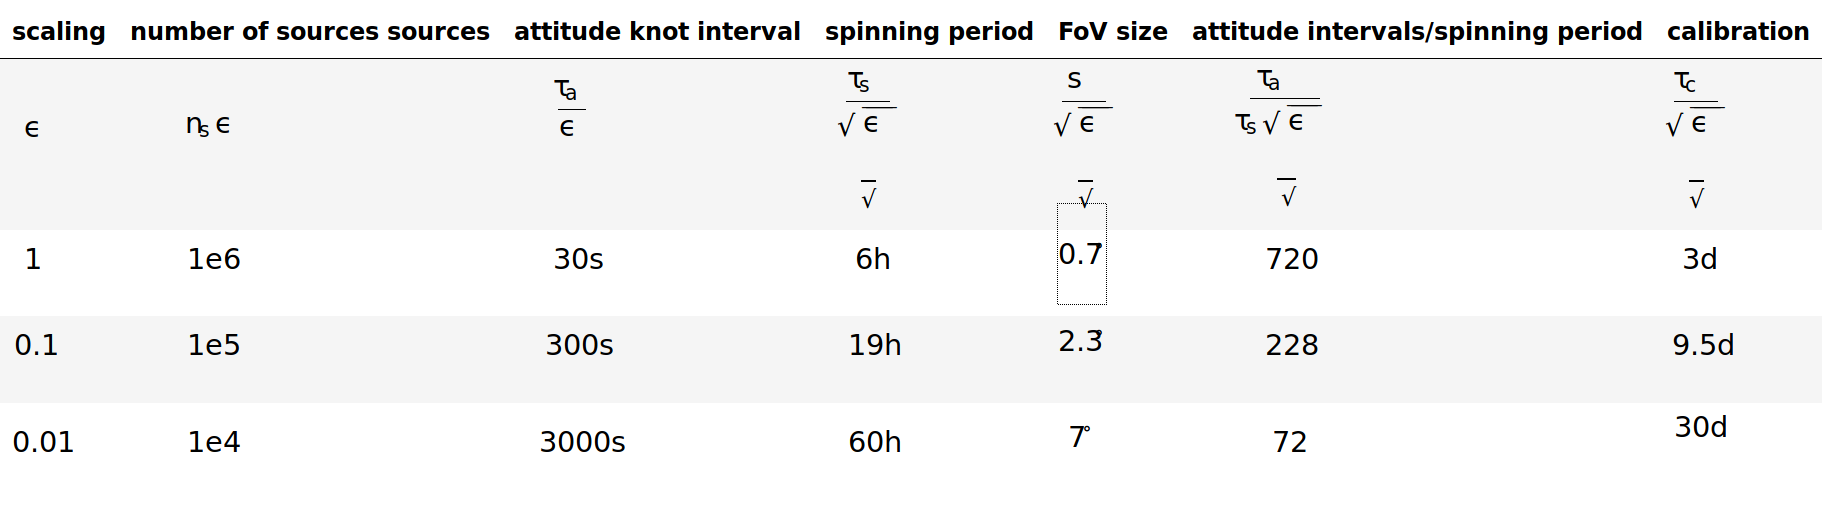

In [2]:
Image('./figures/scaling_factors.png')

# **Initializing objects:**

In [3]:
# # create all the objects we will need:
# parameters for the notebook
t_init = 0 
t_end =  t_init + 1/2
my_dt = 1/24/2 # [days]

# objects
spline_degree = 3

gaia = Satellite(ti=t_init, tf=t_end, dt= my_dt, k=spline_degree)
print('Sat created')

Sat created


In [4]:
double_telescope = True
my_scanner = Scanner(zeta_limit=np.radians(5) ,double_telescope=double_telescope) 
print('Scanner created')

num_sources=9  # has to be divisible by 3

Scanner created


# End scanner

In [5]:
times_for_source = np.linspace(t_init, t_end, num=num_sources//3, endpoint=True)
times_for_source = np.random.rand(num_sources//3)*(t_end-t_init)+t_init

In [6]:
def generate_angles_of_sources(num_sources):
    # Warning be carefull to what you use to get alpha/delta from vector
    # times_for_source = np.linspace(t_init, t_end, num=num_sources, endpoint=True)
    alphas, deltas = ([], [])
    for t in times_for_source:
        noise = np.random.rand(6) *0
        attitude = gaia.func_attitude(t)
        alpha, delta = generate_observation_wrt_attitude(attitude)
        a_P, d_P, a_F, d_F = get_angular_FFoV_PFoV(gaia, t)
        alphas += [alpha + noise[0]]
        deltas += [delta + noise[3]]
        alphas += [ a_P + noise[1], a_F + noise[2]]
        deltas += [ d_P + noise[4], d_F + noise[5]]
    return alphas, deltas

In [7]:
alphas, deltas = generate_angles_of_sources(num_sources)

In [8]:
# create soures from that: 
sources = []
for n in range(num_sources):
    sources.append(Source(str(n), np.degrees(alphas[n]), np.degrees(deltas[n]), 0, 0, 0, 0))
    # sources.append(Source(str(n), alphas[n], deltas[n], parallaxes[n], mu_alphas[n], mu_deltas[n], mu_radials[n]))
print('Sources created')

Sources created


# **Scan**

In [9]:
obs_times = []
calc_sources = []
real_sources = []
for s in sources:
    my_scanner.scan(gaia, s, ti=t_init, tf=t_end)
    my_scanner.compute_angles_eta_zeta(gaia, s)
    print('zetas:', my_scanner.zeta_scanned)
    print('etas:', my_scanner.eta_scanned)
    print('times:', my_scanner.obs_times)
    print('How many observation time?  {}'.format(len(my_scanner.obs_times)))
    if len(my_scanner.obs_times)>0:
        obs_times += my_scanner.obs_times
        print('Error: ', my_scanner.scanner_error())
        real_sources.append(s)
        calc_sources.append(Calc_source(obs_times=my_scanner.obs_times.copy(), source=s))
    print('------------------------------------------------------')
sources = real_sources
obs_times = list(np.sort(obs_times))

zetas: [0.010168956802087521, 0.0016241783810686606, -0.0027931668026253335, -0.011237686585291869]
etas: [1.1102230246251565e-16, -3.3306690738754696e-16, 4.440892098500626e-16, 8.881784197001252e-16]
times: [0.0608614562969877, 0.23690586411709214, 0.3108642393932889, 0.48690410954833896]
How many observation time?  4
Error:  2.7755575615628914e-16
------------------------------------------------------
zetas: [0.017021952205480678, 0.011393463606307285, -3.0357660829594124e-16, -0.005640894789511767]
etas: [0.0, -1.1102230246251565e-16, -3.3306690738754696e-16, -2.220446049250313e-16]
times: [0.023885979534523614, 0.09784269128793338, 0.2738850821527109, 0.34784397857574945]
How many observation time?  4
Error:  -1.6653345369377348e-16
------------------------------------------------------
zetas: [-0.001486995012879287, 0.0001357997323125409, -6.522560269672794e-16, 0.0017684883029957493]
etas: [-1.1102230246251565e-16, -1.1102230246251565e-16, -1.1102230246251565e-16, 0.0]
times: [0

In [10]:
print('t_end: ', t_end)
if list(np.array(obs_times)[np.where(np.array(obs_times)>t_end)]):
    raise ValueError('observed time greater than end time')

t_end:  0.5


# **2- Combine with solver:**

In [11]:
len(obs_times)

36

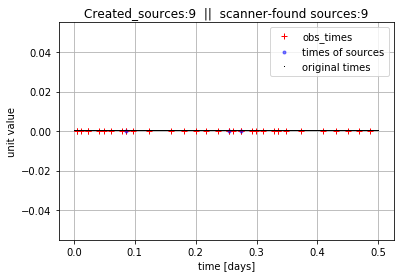

(None, <matplotlib.legend.Legend at 0x7f03483e1908>, None)

In [12]:
plt.figure()
 
plt.title('Created_sources:'+str(num_sources)+'  ||  scanner-found sources:'+str(len(calc_sources)))

plt.plot(obs_times,np.zeros(len(obs_times)), 'r+', label='obs_times')

plt.plot(times_for_source, np.zeros(len(times_for_source)), 'b.', label='times of sources', alpha=0.5)

sampled_times = np.linspace(t_init, t_end, num=500)
plt.plot(sampled_times, np.zeros(len(sampled_times)), 'k,', label='original times')

plt.xlabel('time [days]'), plt.ylabel('unit value') # , plt.ylim((-1e-6, 1e-6))

plt.grid(), plt.legend(), plt.show()

#bins: 24


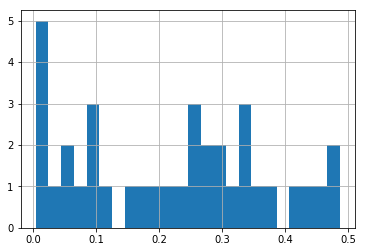

In [13]:
bins = int((t_end-t_init)/my_dt)
print('#bins:', bins)
plt.hist(obs_times, bins=bins, align='mid');
plt.grid();


In [14]:
def noise_calc_sources(s):
    noise = 0.02 / 1000
    s.s_params[0] += noise
    s.s_params[1] += noise
    s.s_params[2] += -s.s_params[2]/100
    s.s_params[3] += s.s_params[3]*0.01
    s.s_params[4] += s.s_params[4]*0.01

In [15]:
tmp_calc_sources = calc_sources.copy()

In [16]:
for s in tmp_calc_sources:
    noise_calc_sources(s)

In [17]:
print('Updating only sources:')
Solver = Agis(gaia, tmp_calc_sources, sources, updating='scanned source', double_telescope=double_telescope)

Updating only sources:


In [18]:
Solver.error_function()

3.195472519630036e-10

In [21]:
# Solver.reset_iterations()
Solver.iterate(10)

***** Iteration: 12 *****
Error after iteration: 5.980650079638439e-07
***** Iteration: 13 *****
Error after iteration: 6.480545931973428e-07
***** Iteration: 14 *****
Error after iteration: 0.019980799536200577
***** Iteration: 15 *****
Error after iteration: 0.04613170365206288
***** Iteration: 16 *****
Error after iteration: 0.22975961067940517
***** Iteration: 17 *****
Error after iteration: 0.02989634433239862
***** Iteration: 18 *****
Error after iteration: 0.08885078746021544
***** Iteration: 19 *****
Error after iteration: 0.07652876196423888
***** Iteration: 20 *****
Error after iteration: 0.21565319563169238
***** Iteration: 21 *****
Error after iteration: 0.013139956913826752


# *Update Attitude*

In [108]:
if len(sources) != len(calc_sources):
    raise ValueError('there must be the same number of real and calc sources')

In [109]:
print('Updating attitude')
spline_degree = 3
Solver = Agis(sat=gaia, calc_sources=calc_sources, real_sources=sources, updating='attitude',
              double_telescope=double_telescope,
              attitude_splines=[gaia.s_w, gaia.s_x, gaia.s_y, gaia.s_z], 
              spline_degree=spline_degree,
              attitude_regularisation_factor=1e-2)

Updating attitude


In [98]:
# Ignore this cell if you don't want to modify the initial attitude
# Can be used to check that when recreating the splines in the solver we (almost) do not create additional errors
my_times = np.array(obs_times)
# Solver.actualise_splines()
print('Error before Noise: ', Solver.error_function())
# print('Errors after noise of attitude (not representatif):', error_between_func_attitudes(my_times, gaia.func_attitude, Solver.get_attitude))
c_noise = Solver.att_coeffs * np.random.rand(Solver.att_coeffs.shape[0], Solver.att_coeffs.shape[1]) * 1e-6
print('c_noise shape: ', c_noise.shape)
last_coef = 4
#Solver.att_coeffs[:last_coef] = Solver.att_coeffs[:last_coef] + c_noise[:last_coef]
Solver.actualise_splines()
#Solver.set_splines_basis()
print('Error after Noise: ', Solver.error_function())
# print('Errors after noise of attitude (not representatif):', error_between_func_attitudes(my_times, gaia.func_attitude, Solver.get_attitude))

Error before Noise:  3.041801910597773e-19
c_noise shape:  (4, 25)
Error after Noise:  3.041801910597773e-19


In [37]:
Solver.update_A_block(use_sparse=False)

N_aa_dim: 37


In [38]:
Solver.error_function()

1.0381243502753154e-07

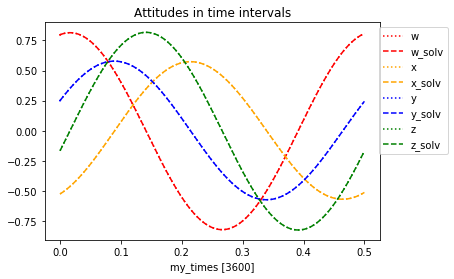

In [23]:
compare_attitudes(gaia, Solver, obs_times)

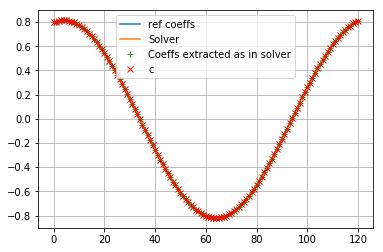

(None, <matplotlib.legend.Legend at 0x7fa3ff2c99b0>, None)

In [24]:
to_fit = gaia.s_w
c, t, s = extract_coeffs_knots_from_splines([gaia.s_w, gaia.s_x, gaia.s_y, gaia.s_z], k=3)
a_ref = to_fit.get_coeffs()
plt.plot(a_ref, label='ref coeffs')
plt.plot(Solver.att_coeffs[0], label='Solver')
plt.plot(c[0], '+', label='Coeffs extracted as in solver')
plt.plot(Solver.c[0], 'rx', label='c')
plt.grid(), plt.legend(), plt.show()

**Plot matrices:**

In [25]:
if (Solver.att_knots.shape[0] - Solver.att_coeffs.shape[1]) != 4:
    raise ValueError('there should be 4 coeffs less than the number of knots')

In [26]:
N_aa = Solver.compute_attitude_LHS()

N_aa_dim: 121


In [27]:
N_aa_w = N_aa[0::4, 0::4]
N_aa_x = N_aa[1::4, 1::4]
N_aa_y = N_aa[2::4, 2::4]
N_aa_z = N_aa[3::4, 3::4]
N_aa_list = [N_aa_w, N_aa_x, N_aa_y, N_aa_z]
print('N_aa_w.shape', N_aa_w.shape)
print('N_aa_z.shape', N_aa_z.shape)

N_aa_w.shape (121, 121)
N_aa_z.shape (121, 121)


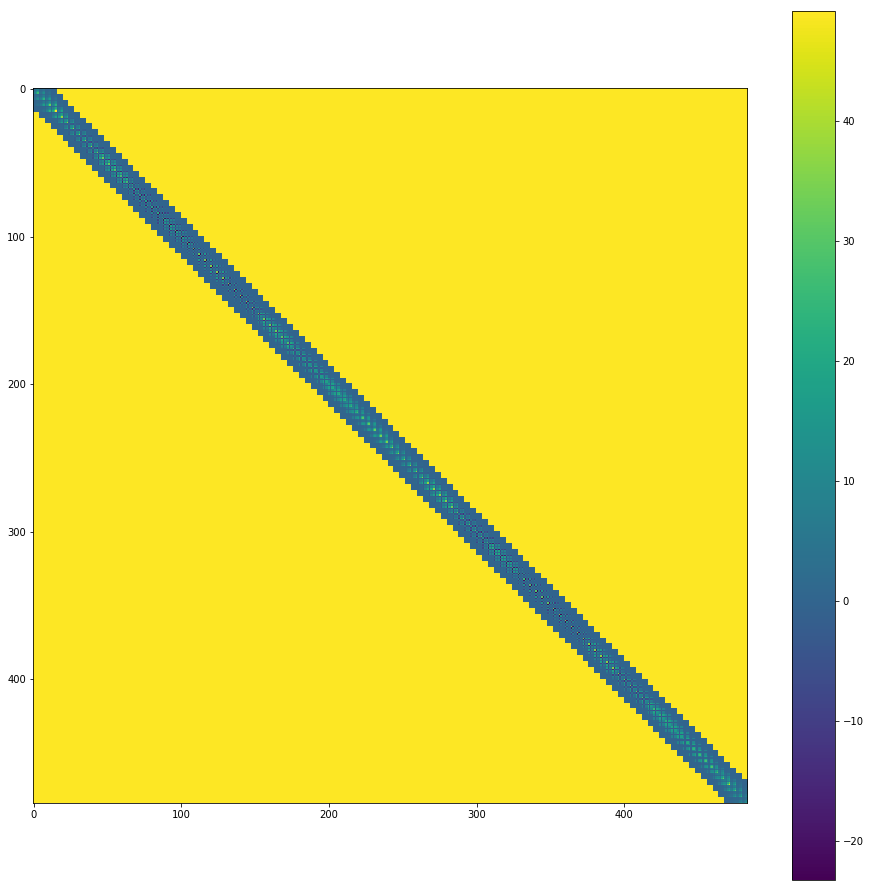

In [28]:
A=N_aa
plt.figure(figsize=(16,16))
threshold = 0
A[np.where(A==threshold)] = A.max()
plt.imshow(A, vmin=None, vmax=None)
plt.colorbar()
#fig.colorbar(plot1, ax=plt)

Text(0.5, 0.98, 'Matrix visualization')

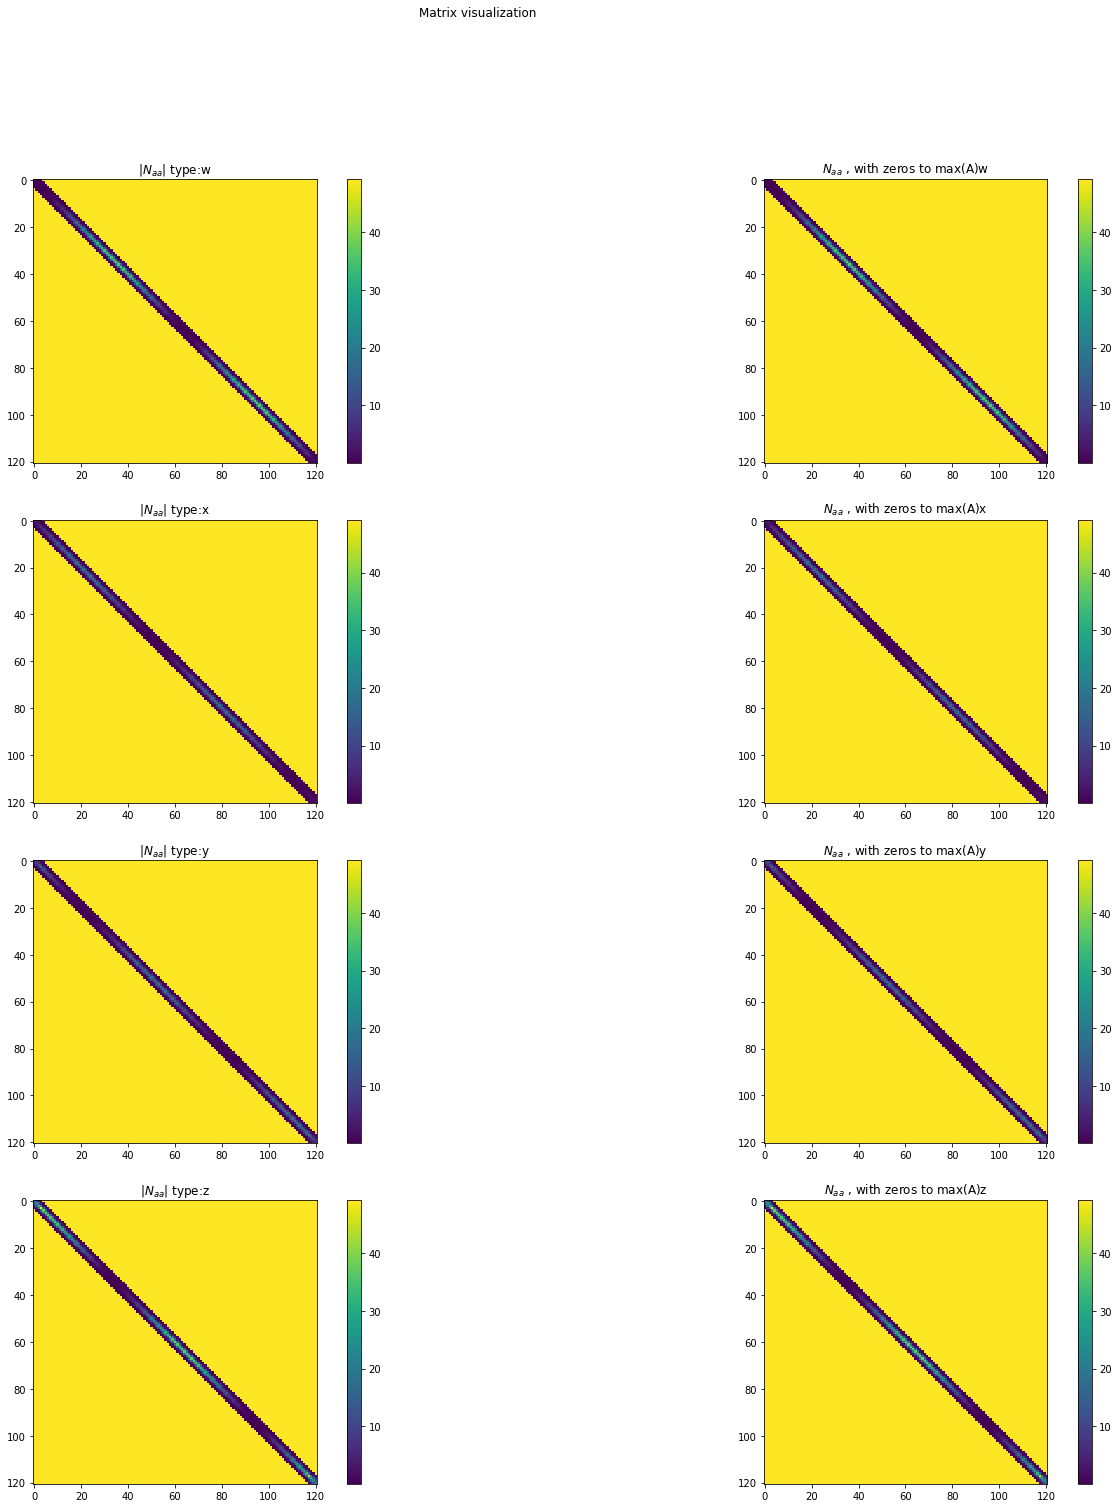

In [29]:
fig, axs = plt.subplots(4, 2, figsize=(24, 24))

type_list = ['w', 'x', 'y', 'z']
for i in range(4):
    A = N_aa_list[i].copy()
    plot1 = axs[i, 0].imshow(np.abs(A), vmin=None, vmax=None)
    axs[i, 0].set_title("$|N_{aa}|$ type:"+type_list[i])
    
    threshold = 0
    A[np.where(A==threshold)] = A.max()
    plot2 = axs[i, 1].imshow(A, vmin=None, vmax=None)
    axs[i, 1].set_title("$N_{aa}$ , with zeros to max(A)"+type_list[i])

    fig.colorbar(plot1, ax=axs[i, 0])
    fig.colorbar(plot2, ax=axs[i, 1])
    
fig.suptitle('Matrix visualization')
# plt.show()

In [30]:
Solver.att_coeffs.shape

(4, 121)

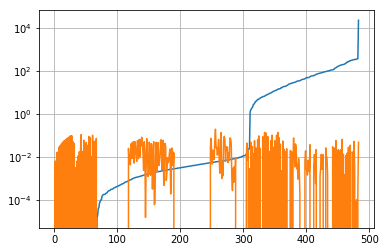

In [31]:
eig_vals, eig_vecs = np.linalg.eigh(N_aa)
plt.plot(eig_vals, label=type_list[i])
    
plt.yscale('log')
# plt.xlim(0,5)
# plt.show()


plt.plot(eig_vecs[0])
#plt.xlim(100,110)
plt.grid()
plt.show()

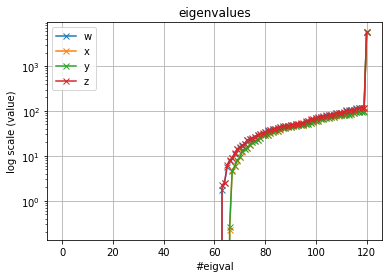

In [32]:
plt.figure()
for i, Naa in enumerate(N_aa_list):
    eig_vals, eig_vecs = np.linalg.eigh(Naa)
    plt.plot(eig_vals, label=type_list[i],marker='x')
    if not helpers.check_symmetry(Naa):
        raise ValueError('Matrix not symmetric')
    # print('Condition number: ', np.linalg.cond(Naa))
    # print('Condition number (eig_max/eig_min): ', np.abs(eig_vals.max())/np.abs(eig_vals.min()))
    # print('Rank: ', np.linalg.matrix_rank(Naa, hermitian=True))
    # print('det(N_aa):', np.linalg.det(Naa),'\n')
plt.yscale('log'), plt.legend(), plt.grid()
plt.title('eigenvalues'), plt.ylabel('log scale (value)'), plt.xlabel('#eigval')
# plt.xlim((0,5))

plt.show()

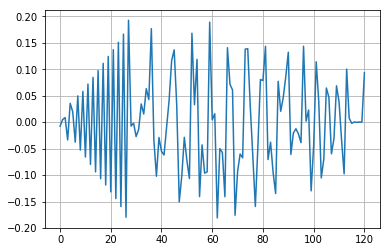

In [33]:
eig_vals, eig_vecs = np.linalg.eigh(N_aa_list[2])
plt.plot(eig_vecs[0])
plt.grid()

# **See iterations**

***** Iteration: 1 *****
N_aa_dim: 121
attitude error: 3.8331172224821165e-05
Error after iteration: 1.2817318192728208e-12


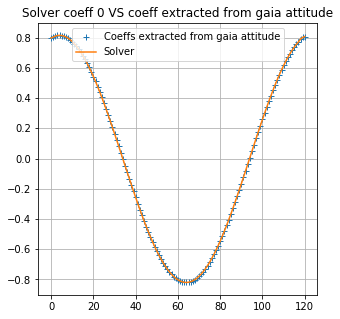

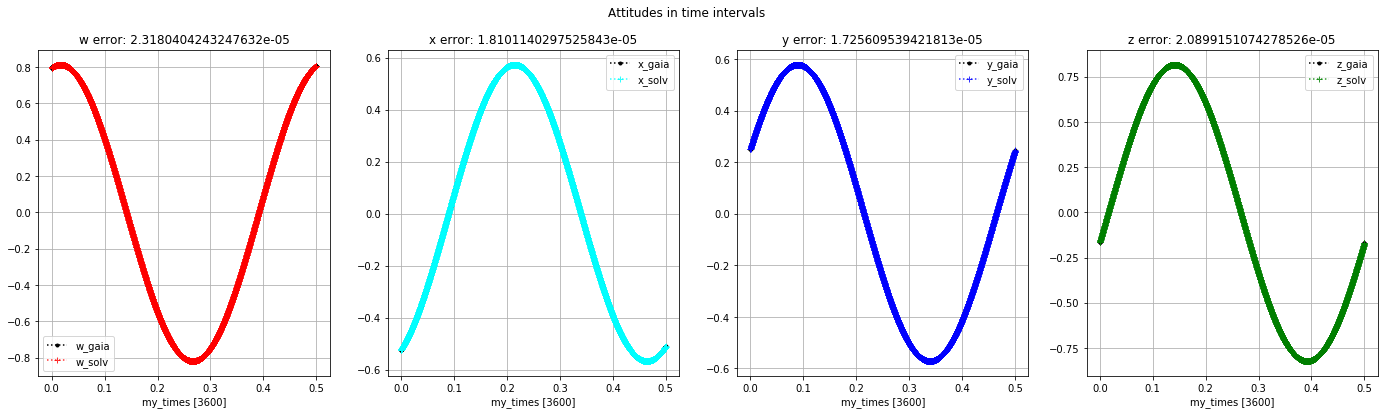

MAGNITUDE: 0.9999999316181906


In [34]:
Solver.verbose=False
# Solver.reset_iterations()
Solver.iterate(1)

plt.figure(figsize=(5,5))
c, t, s = extract_coeffs_knots_from_splines([gaia.s_w, gaia.s_x, gaia.s_y, gaia.s_z], k=3)
plt.plot(c[0], '+', label='Coeffs extracted from gaia attitude')
plt.plot(Solver.att_coeffs[0], label='Solver')
plt.title('Solver coeff 0 VS coeff extracted from gaia attitude')
plt.grid(), plt.legend(), plt.show()
fig2 = multi_compare_attitudes(gaia, Solver, obs_times)
print('MAGNITUDE:', Solver.get_attitude(0.005, unit=False).magnitude)
fig2.savefig('figures/tmp/lala.png')

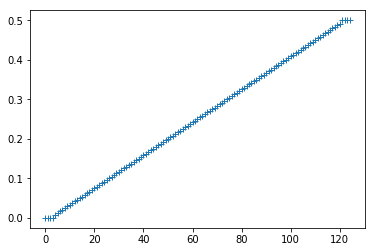

In [35]:
plt.plot(Solver.att_knots, '+')
plt.show()

In [36]:
Solver.iterate(100)

***** Iteration: 2 *****
N_aa_dim: 121
attitude error: 0.0012676836519190404
Error after iteration: 1.4704065194538857e-09
***** Iteration: 3 *****
N_aa_dim: 121
attitude error: 0.25069786593922055
Error after iteration: 5.616887702103758e-05
***** Iteration: 4 *****
N_aa_dim: 121
attitude error: 79.05155259415574
Error after iteration: 10.837307926684138
***** Iteration: 5 *****
N_aa_dim: 121


KeyboardInterrupt: 

In [ ]:
fig2 = multi_compare_attitudes(gaia, Solver, obs_times)


In [ ]:
B = A.copy()
A = Solver.compute_attitude_LHS()
print((B-A).sum())

In [ ]:
hi = h
h = Solver.compute_attitude_RHS()
print((hi-h).sum())

In [38]:
Solver.update_A_block(use_sparse=True)

AttributeError: 'Agis' object has no attribute 'compute_sparses_matrices'